---
title: "Attention Mechanisms: Memory-Efficient Techniques and Implementations"
date: "2025-01-12"
categories: ["Machine Learning"]
---

In [28]:
import torch
import torch.nn as nn
import math
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import seaborn as sns

# Attention Mechanisms: Memory-Efficient Techniques and Implementations

In this notebook, we explore various attention mechanisms used in deep learning, focusing on their memory usage and efficiency. We begin with a fundamental comparison between Multi-Head Attention (MHA) and Group Query Attention, highlighting how the latter reduces memory requirements by sharing key-value matrices across multiple query heads.

We then delve into the concept of Multi-Query Attention, which further optimizes memory by using a single key-value matrix for all query heads. To take memory efficiency to the next level, we introduce Multi-Head Latent Attention (MLA), a technique that compresses the key-value matrices into a lower-dimensional latent space, drastically reducing memory usage while maintaining the ability to compute attention.

Throughout the notebook, we provide detailed explanations of these techniques, including their memory usage formulas, followed by Python implementations of each attention mechanism to demonstrate their practical applications. The goal is to provide both theoretical insights and hands-on experience in optimizing attention mechanisms for large-scale models.


### Word of Caution
* Self-Learning Tool: This notebook is primarily a personal self-learning resource. As a hobbyist passionate about learning and sharing, I’ve put this together to better understand and experiment with various attention mechanisms. The explanations and code are meant to be accessible to those interested in the same journey.
* Performance Not Optimized: The implementations provided here are not optimized for production-level performance. For example, real-world applications typically use optimized libraries like Flash Attention, but in this notebook, the focus is on simplicity and clarity. The code is written to be easily understandable, not for efficiency at scale.
* Incomplete Implementations: While the core attention mechanisms are implemented, the notebook does not include all real-world enhancements. For instance, positional encodings, such as RoPE (Rotary Positional Encoding), are not integrated here but are an essential part of most attention mechanisms in practical applications.
* No Ablation Studies: This notebook does not attempt to conduct ablation studies or determine which attention mechanism is "better" in terms of performance or accuracy. The goal is not to provide a comprehensive comparison but rather to explore and observe how different attention mechanisms affect memory usage and performance in a simplified context.

In [29]:
MAX_BATCH_SIZE = 16 if not torch.cuda.is_available() else 32
MAX_SEQ_LEN = 128 if not torch.cuda.is_available() else 2048

## Multi-Head Attention


Multi-Head Attention is a core component of transformer models that allows the model to focus on different parts of the input sequence simultaneously. It involves multiple attention heads, each computing scaled dot-product attention independently, followed by a concatenation of the results and a final linear transformation.

![MHA](img/multi-head-attention_l1A3G7a.png)

#### 1. Input Transformation:
For an input sequence $X \in \mathbb{R}^{T \times d_{\text{model}}}$, where $T$ is the sequence length and $d_{\text{model}}$ is the model's hidden size, the inputs are transformed into query, key, and value matrices:

$$
Q = X W_Q, \quad K = X W_K, \quad V = X W_V
$$

Here:

- $W_Q, W_K, W_V \in \mathbb{R}^{d_{\text{model}} \times d_k}$ are learnable projection matrices.
- $Q, K, V \in \mathbb{R}^{T \times d_k}$


#### 2. Scaled Dot-Product Attention:
For a single attention head, attention scores are computed as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^\top}{\sqrt{d_k}}\right)V
$$

Here:

- $Q K^\top \in \mathbb{R}^{T \times T}$ represents the similarity scores between queries and keys.
- $\frac{1}{\sqrt{d_k}}$ is a scaling factor to prevent large values in the softmax.
- $\text{softmax}(\cdot)$ normalizes the scores across the sequence.


#### 3. Multi-Head Attention:
Splitting $d_{\text{model}}$ into multiple heads in Multi-Head Attention allows the model to focus on different parts of the input sequence simultaneously. Each attention head operates on a subset of the dimensions ($d_k = d_{\text{model}} / h$), enabling the model to capture diverse patterns or relationships in the data, such as local and global dependencies.

This parallel processing improves the expressiveness of the attention mechanism, allowing it to learn richer representations compared to a single attention head. By combining the outputs of all heads, the model integrates these diverse perspectives into a more comprehensive understanding of the input.

Instead of using a single attention head, multiple heads are used. Each head has its own projection matrices $W_Q^i, W_K^i, W_V^i$ and computes attention independently:

$$
\text{head}_i = \text{Attention}(Q W_Q^i, K W_K^i, V W_V^i)
$$

The outputs of all heads are concatenated and projected back to $d_{\text{model}}$:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W_O
$$

Here:

- $W_O \in \mathbb{R}^{(h \cdot d_k) \times d_{\text{model}}}$ is a projection matrix for combining all heads.
- $h$ is the number of attention heads.

In [30]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim: int, n_heads: int):
        super().__init__()
        # Total embedding dimension
        self.dim = dim
        # Number of attention heads
        self.n_heads = n_heads
        # Dimension of each attention head
        self.head_dim = dim // n_heads
        # Query projection matrix: maps input to query vectors
        self.wq = nn.Linear(dim, dim)
        # Key projection matrix: maps input to key vectors
        self.wk = nn.Linear(dim, dim)
        # Value projection matrix: maps input to value vectors
        self.wv = nn.Linear(dim, dim)
        # Output projection matrix: combines and maps attention outputs back to model dimension
        self.wo = nn.Linear(dim, dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input shape: (batch_size, seq_len, dim)
        batch_size, seq_len, _ = x.shape

        # Linear projections - output shapes: (batch_size, seq_len, dim)
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)

        # Reshape to separate heads and transpose to get shape:
        # (batch_size, n_heads, seq_len, head_dim)
        q = q.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        # q @ k.T shape: (batch_size, n_heads, seq_len, seq_len)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Create causal mask of shape (seq_len, seq_len)
        mask = torch.tril(torch.ones(seq_len, seq_len)).to(x.device)
        scores = scores.masked_fill(mask == 0, float("-inf"))
        scores = scores.softmax(dim=-1)  # Normalize scores

        # Apply attention to values
        # output shape: (batch_size, n_heads, seq_len, head_dim)
        output = torch.matmul(scores, v)

        # Reshape back to (batch_size, seq_len, dim)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        return self.wo(output)  # Final linear projection

## Multi-Head Attention with KV Cache

Multi-Head Attention with KV Cache is an optimization technique used in transformer models to improve efficiency during autoregressive tasks, such as language generation. Instead of recomputing the key ($K$) and value ($V$) matrices for all tokens in the sequence at each step, previously computed $K$ and $V$ are cached and reused.

![KV Cache](img/key-value-caching_.png)

### Key Differences and Modifications

#### Caching Keys and Values
In standard Multi-Head Attention, $K$ and $V$ are recomputed for the entire input sequence. With KV caching, only the new token's query ($Q$) is processed, while $K$ and $V$ from previous steps are stored and concatenated:

$$
K_{\text{cached}} = \text{Concat}(K_{\text{prev}}, K_{\text{new}}), \quad V_{\text{cached}} = \text{Concat}(V_{\text{prev}}, V_{\text{new}})
$$

Here:
- $K_{\text{prev}}$ and $V_{\text{prev}}$ are the cached keys and values from earlier time steps.
- $K_{\text{new}}$ and $V_{\text{new}}$ are the keys and values for the current token.

#### Computing Attention
The attention mechanism remains the same but operates over the concatenated cached keys and values:

$$
\text{Attention}(Q, K_{\text{cached}}, V_{\text{cached}}) = \text{softmax}\left(\frac{Q K_{\text{cached}}^\top}{\sqrt{d_k}}\right)V_{\text{cached}}
$$

### Efficiency
- **Reduced Redundancy**: By caching, recomputation of \( K \) and \( V \) for all tokens is avoided, significantly speeding up inference for long sequences.
- **Scalability**: This makes the model more memory-efficient, especially for real-time or autoregressive tasks like text generation.


In [31]:
class MultiHeadAttentionKVCache(nn.Module):
    def __init__(self, dim: int, n_heads: int):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.wq = nn.Linear(dim, dim)
        self.wk = nn.Linear(dim, dim)
        self.wv = nn.Linear(dim, dim)
        self.wo = nn.Linear(dim, dim)

        self.register_buffer(
            "cache_k",
            torch.zeros(MAX_BATCH_SIZE, MAX_SEQ_LEN, self.n_heads, self.head_dim),
        )
        self.register_buffer(
            "cache_v",
            torch.zeros(MAX_BATCH_SIZE, MAX_SEQ_LEN, self.n_heads, self.head_dim),
        )

    def forward(self, x: torch.Tensor, start_pos: int) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape
        assert seq_len == 1, "seq_len must be 1"
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)

        q = q.view(batch_size, seq_len, self.n_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.n_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.n_heads, self.head_dim)

        # Store current k,v in cache at position start_pos
        # k shape: (batch_size, 1, n_heads, head_dim)
        # cache_k shape: (MAX_BATCH_SIZE, MAX_SEQ_LEN, n_heads, head_dim)
        self.cache_k[:batch_size, start_pos : start_pos + seq_len, :, :] = k
        self.cache_v[:batch_size, start_pos : start_pos + seq_len, :, :] = v

        # Retrieve cached k,v up to current position for attention computation
        # Retrieved k shape: (batch_size, start_pos+1, n_heads, head_dim)
        # This allows attending to all previous tokens plus current token
        k = self.cache_k[:batch_size, : start_pos + seq_len, :, :]
        v = self.cache_v[:batch_size, : start_pos + seq_len, :, :]

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        scores = scores.softmax(dim=-1)
        output = torch.matmul(scores, v)
        # Concatenate heads and apply output projection
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        return self.wo(output)

## Group Query Attention with KV Cache

Group Query Attention with KV Cache is an extension of multi-head attention where multiple query heads attend to the same cached key and value pairs. This allows the model to efficiently process key-value caches while reusing the same key-value heads across multiple queries, improving performance, especially in autoregressive tasks.

![GQA](img/what-is-grouped-query-attention-gqa.32669ace.png)

### Key Differences and Modifications

#### Grouping Query Heads
Instead of having separate key-value heads for each query head, the model groups query heads that attend to the same cached key and value heads. The number of query heads per group is determined by dividing the total number of query heads by the number of key-value heads.

$$
\text{kv\_per\_head} = \frac{n_{\text{heads}}}{n_{\text{kv\_heads}}}
$$

#### Key and Value Caching
As the attention mechanism processes input tokens, the keys ($K$) and values ($V$) for earlier tokens are cached to avoid recomputation in subsequent time steps. These cached keys and values are stored in buffers, which are updated at each new time step:

$$
\text{cache } K[:, \text{start\_pos}: \text{start\_pos}+1, :, :] = K
$$
$$
\text{cache } V[:, \text{start\_pos}: \text{start\_pos}+1, :, :] = V
$$

The cached keys and values are then used in the computation of attention scores, reducing the need for recalculating them for each new token.

#### Attention Computation
For each query head in the group, attention is computed over the cached keys and values. The key and value matrices are repeated across multiple query heads (i.e., the $K$ and $V$ tensors are repeated $\text{kv\_per\_head}$ times) to account for multiple query heads attending to the same set of key-value heads:

$$
K = K \cdot \text{repeat\_interleave}(\text{kv\_per\_head}, \text{dim}=1)
$$
$$
V = V \cdot \text{repeat\_interleave}(\text{kv\_per\_head}, \text{dim}=1)
$$

#### Scaled Dot-Product Attention
The attention scores are computed as the dot product between the queries and the keys, followed by a scaling factor to normalize the scores:

$$
\text{scores} = \frac{Q K^\top}{\sqrt{d_k}}
$$

Here, $Q$ is the query matrix, $K^\top$ is the transpose of the key matrix, and $d_k$ is the dimensionality of the key vectors.

The attention scores are then normalized using softmax:

$$
\text{scores} = \text{softmax}(\text{scores}, \text{dim}=-1)
$$

These attention scores are then used to weight the values:

$$
\text{output} = \text{scores} \cdot V
$$


In [32]:
class GroupQueryAttentionKVCache(nn.Module):
    def __init__(self, dim: int, n_heads: int, n_kv_heads: int):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.kv_per_head = n_heads // n_kv_heads
        assert (
            self.kv_per_head * self.n_kv_heads == self.n_heads
        ), "n_kv_heads must be a divisor of n_heads"
        self.head_dim = dim // n_heads
        assert self.head_dim * self.n_heads == dim, "dim must be a multiple of n_heads"
        self.wq = nn.Linear(dim, dim)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim)
        self.wo = nn.Linear(dim, dim)

        self.register_buffer(
            "cache_k",
            torch.zeros(MAX_BATCH_SIZE, MAX_SEQ_LEN, self.n_kv_heads, self.head_dim),
        )
        self.register_buffer(
            "cache_v",
            torch.zeros(MAX_BATCH_SIZE, MAX_SEQ_LEN, self.n_kv_heads, self.head_dim),
        )

    def forward(self, x: torch.Tensor, start_pos: int):
        batch_size, seq_len, _ = x.shape
        assert seq_len == 1, "seq_len must be 1"

        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)

        q = q.view(batch_size, seq_len, self.n_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)

        self.cache_k[:batch_size, start_pos : start_pos + seq_len, :, :] = k
        self.cache_v[:batch_size, start_pos : start_pos + seq_len, :, :] = v

        k = self.cache_k[:batch_size, : start_pos + seq_len, :, :]
        v = self.cache_v[:batch_size, : start_pos + seq_len, :, :]

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # repeat each head of k, v self.kv_per_head times
        k = k.repeat_interleave(self.kv_per_head, dim=1)
        v = v.repeat_interleave(self.kv_per_head, dim=1)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        scores = scores.softmax(dim=-1)
        output = torch.matmul(scores, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        return self.wo(output)

## Multi-Head Latent Attention (MLA)

In **Multi-Head Latent Attention (MLA)**, a key technique is the **low-rank joint compression** of the key and value matrices to significantly reduce memory usage in the key-value (KV) cache. This technique is particularly useful for long sequences, where the KV cache size could become a bottleneck.

![MLA](img/mla.png)

#### 1. Low-Rank Key-Value Compression

The MLA approach starts by compressing the keys and values jointly into a smaller latent space, reducing the memory requirement for storing them. The key operations are:

- **Down-Projection**: The original key-value matrix $h_t$ (size $d \times n_{\text{heads}}$) is projected down to a lower-dimensional latent space $c_{KV_t}$ (size $d_c$) using the down-projection matrix $W_{D_{KV}}$:

  $$
  c_{KV_t} = W_{D_{KV}} h_t
  $$

  Where $W_{D_{KV}} \in \mathbb{R}^{d_c \times d}$ is the down-projection matrix, and $d_c$ is the latent dimension, which is significantly smaller than the original dimensionality $d_{\text{model}}$.

- **Up-Projection**: After compression, the compressed keys and values are restored to their original dimensions for use in attention computation through the up-projection matrices $W_{U_K}$ for keys and $W_{U_V}$ for values:

  $$
  k_{C_t} = W_{U_K} c_{KV_t}, \quad v_{C_t} = W_{U_V} c_{KV_t}
  $$

  Here, $W_{U_K} \in \mathbb{R}^{d_{\text{model}} \times d_c}$ and $W_{U_V} \in \mathbb{R}^{d_{\text{model}} \times d_c}$ are the up-projection matrices for keys and values, respectively.

The benefit of this low-rank joint compression is that it significantly reduces the memory footprint of the KV cache. Specifically, instead of storing the full-sized key and value matrices, we only store the compressed latent vectors $c_{KV_t}$, which require much less space.

#### 2. Key-Value Cache Reduction

During inference, the compressed vectors $c_{KV_t}$ are cached, significantly reducing the memory required for storing keys and values across layers. The total size of the KV cache is proportional to $d_c$ (the compressed latent dimension), which is much smaller than the original dimensionality.

In practical terms, the KV cache has only $d_c \times l$ elements (where $l$ is the number of layers), instead of the full-size key-value matrices for each layer.

#### 3. Query Compression

In addition to compressing the keys and values, MLA also compresses the queries to further reduce the activation memory during training. This compression is done through similar down-projection and up-projection steps:

- **Down-Projection of Queries**: The queries $h_t$ are projected down into a smaller latent vector $c_{Q_t}$ using the down-projection matrix $W_{D_Q}$:

  $$
  c_{Q_t} = W_{D_Q} h_t
  $$

  Where $W_{D_Q} \in \mathbb{R}^{d'_c \times d}$ is the down-projection matrix, and $d'_c$ is the query compression dimension.

- **Up-Projection of Queries**: The compressed query $c_{Q_t}$ is restored to its original dimensions using the up-projection matrix $W_{U_Q}$:

  $$
  q_{C_t} = W_{U_Q} c_{Q_t}
  $$

  Where $W_{U_Q} \in \mathbb{R}^{d_{\text{model}} \times d'_c}$ is the up-projection matrix for queries.

This query compression reduces the memory needed for the query representations, helping to alleviate memory pressure during training.

#### 4. Inference Optimization

During inference, additional optimizations are possible. Specifically, the up-projection matrices for keys $W_{U_K}$ and values $W_{U_V}$ can be absorbed into the projection matrices $W_Q$ and $W_O$, respectively, for queries and outputs. This means that the keys and values do not need to be computed explicitly during inference, further reducing memory and computation costs.

#### Summary of MLA's Key Components:

- **Key-Value Compression**: Low-rank joint compression reduces memory usage for keys and values in the KV cache.
- **Query Compression**: Compresses queries to reduce activation memory during training.
- **Inference Optimizations**: Absorption of up-projection matrices into the query and output projections eliminates the need for recomputing keys and values.
- **Reduced KV Cache Size**: Only the compressed latent vectors $c_{KV_t}$ need to be cached, which significantly reduces memory usage.

#### Mathematical Notation Recap:

- **Compressed Latent Vector for Keys and Values**: $c_{KV_t} = W_{D_{KV}} h_t$
- **Up-Projection of Keys and Values**: $k_{C_t} = W_{U_K} c_{KV_t}, \quad v_{C_t} = W_{U_V} c_{KV_t}$
- **Compressed Latent Vector for Queries**: $c_{Q_t} = W_{D_Q} h_t$
- **Up-Projection of Queries**: $q_{C_t} = W_{U_Q} c_{Q_t}$

By reducing the size of the KV cache and compressing the queries, MLA offers substantial memory savings while maintaining the performance of attention mechanisms.


There are two ways to implement MLA:

1. Decompress KV: decompress the key and value matrices to the original dimension before storing them in the cache
2. Compress KV: compress the key and value matrices to a lower dimension and store them in the cache

**Why would we want to decompress the key and value matrices to the original dimension?**

Although decompressing the key and value matrices to the original dimension is memory inefficient, it's generally faster to compute attention scores and apply them to the values. Vs in the compressed version we would have to recompute all the past key and value matrices from the compressed latent vectors before computing the attention scores.


In [33]:
class MultiHeadLatentAttentionDecompressKV(nn.Module):
    def __init__(
        self, dim: int, n_heads: int, q_compression_dim: int, kv_compression_dim: int
    ):
        super().__init__()
        assert dim % n_heads == 0, "dim must be divisible by n_heads"
        self.dim = dim
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.kv_compression_dim = kv_compression_dim

        # Query compression weights
        # w_dq: Projects query from full dim to compressed dim (down projection)
        self.w_dq = nn.Linear(dim, q_compression_dim)
        # w_uq: Projects query back from compressed to full dim (up projection)
        self.w_uq = nn.Linear(q_compression_dim, dim)

        # Key-Value compression weights
        # w_dkv: Projects both key and value to shared compressed dim
        self.w_dkv = nn.Linear(dim, kv_compression_dim)
        # w_uk, w_uv: Separate projections from compressed dim back to full dim
        self.w_uk = nn.Linear(kv_compression_dim, dim)
        self.w_uv = nn.Linear(kv_compression_dim, dim)

        # Final output projection
        self.w_o = nn.Linear(dim, dim, bias=False)

        # KV Cache buffers to store previous key/value pairs
        self.register_buffer(
            "cache_k",
            torch.zeros(MAX_BATCH_SIZE, MAX_SEQ_LEN, self.n_heads, self.head_dim),
        )
        self.register_buffer(
            "cache_v",
            torch.zeros(MAX_BATCH_SIZE, MAX_SEQ_LEN, self.n_heads, self.head_dim),
        )

    def forward(self, x: torch.Tensor, start_pos: int):
        # Input shape: (batch_size, seq_len, dim)
        batch_size, seq_len, _ = x.shape
        assert (
            seq_len == 1
        ), "Only single-step inference (seq_len=1) is supported for MLA."

        # Project to compressed q dimension: (batch_size, seq_len, q_compression_dim)
        c_q = self.w_dq(x)
        # Project back to full dimension: (batch_size, seq_len, dim)
        q = self.w_uq(c_q)

        # Project to compressed kv dimension: (batch_size, seq_len, kv_compression_dim)
        c_kv = self.w_dkv(x)

        # Project back to full dimension: (batch_size, seq_len, dim)
        k = self.w_uk(c_kv)
        v = self.w_uv(c_kv)

        # Reshape to split dim into n_heads and head_dim
        # q shape: (batch_size, seq_len, n_heads, head_dim)
        q = q.view(batch_size, seq_len, self.n_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.n_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.n_heads, self.head_dim)

        # Cache k,v for current position
        self.cache_k[:batch_size, start_pos : start_pos + seq_len, :, :] = k
        self.cache_v[:batch_size, start_pos : start_pos + seq_len, :, :] = v

        # Get cached k,v up to current position
        k = self.cache_k[:batch_size, : start_pos + seq_len, :, :]
        v = self.cache_v[:batch_size, : start_pos + seq_len, :, :]

        # Transpose to get shape (batch_size, n_heads, seq_len, head_dim)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Compute attention scores: (batch_size, n_heads, seq_len, seq_len)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attention = F.softmax(scores, dim=-1)

        # Apply attention: (batch_size, n_heads, seq_len, head_dim)
        context = torch.matmul(attention, v)

        # Reshape back to (batch_size, seq_len, dim)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.w_o(context)

        return output

In [34]:
class MultiHeadLatentAttentionCompressKV(nn.Module):
    def __init__(
        self, dim: int, n_heads: int, q_compression_dim: int, kv_compression_dim: int
    ):
        super().__init__()
        assert dim % n_heads == 0, "dim must be divisible by n_heads"
        self.dim = dim
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.kv_compression_dim = kv_compression_dim

        # Down-project query from dim to compressed dimension
        self.w_dq = nn.Linear(dim, q_compression_dim)
        # Up-project query back to original dimension
        self.w_uq = nn.Linear(q_compression_dim, dim)

        # Down-project key-value to shared compressed dimension
        self.w_dkv = nn.Linear(dim, kv_compression_dim)
        # Separate up-projections for key and value back to original dimension
        self.w_uk = nn.Linear(kv_compression_dim, dim)
        self.w_uv = nn.Linear(kv_compression_dim, dim)

        # Final output projection
        self.w_o = nn.Linear(dim, dim, bias=False)

        # Cache for storing compressed key-value pairs during generation
        self.register_buffer(
            "cache_kv", torch.zeros(MAX_BATCH_SIZE, MAX_SEQ_LEN, kv_compression_dim)
        )

    def forward(self, x: torch.Tensor, start_pos: int):
        batch_size, seq_len, _ = x.shape
        assert (
            seq_len == 1
        ), "Only single-step inference (seq_len=1) is supported for MLA."

        # Project to compressed q dimension: (batch_size, seq_len, q_compression_dim)
        c_q = self.w_dq(x)
        # Project back to full dimension: (batch_size, seq_len, dim)
        q = self.w_uq(c_q)

        # Project to compressed kv dimension: (batch_size, seq_len, kv_compression_dim)
        c_kv = self.w_dkv(x)

        # Cache compressed kv for current position
        self.cache_kv[:batch_size, start_pos : start_pos + seq_len, :] = c_kv

        # Retrieve cached kv up to current position
        cached_kv = self.cache_kv[:batch_size, : start_pos + seq_len, :]

        # Project back to full dimension: (batch_size, seq_len, dim)
        k = self.w_uk(cached_kv)
        v = self.w_uv(cached_kv)

        # Reshape to get shape (batch_size, n_heads, seq_len, head_dim)
        q = q.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        # seq_len is not the same as the seq_len of the input which is 1, it is the seq_len of the cached kv
        # hence we need to view it with -1 to get the correct shape
        k = k.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attention = F.softmax(scores, dim=-1)

        context = torch.matmul(attention, v)

        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.w_o(context)

        return output

## Memory Usage Comparison

#### 1. Memory Usage in Multi-Head Attention
In Multi-Head Attention (MHA), for each query, separate key-value heads are used. This means for each query head, there is a corresponding set of keys and values. The size of the key and value matrices increases with the number of heads, leading to higher memory requirements.

For an input sequence of length $T$, model dimension $d_{\text{model}}$, and number of attention heads $n_{\text{heads}}$, the memory required for storing keys and values is proportional to:

$$
\text{Memory}_{\text{keys/values}} = T \times d_k \times n_{\text{heads}}
$$

where $d_k = \frac{d_{\text{model}}}{n_{\text{heads}}}$ is the dimension of each head.

**Key and Value Memory:**

In MHA, each query head has its own unique key and value projections, so the memory for storing keys and values grows with $n_{\text{heads}}$, the number of heads.

#### 2. Memory Usage in Group Query Attention
In Group Query Attention, multiple query heads share the same key and value heads, significantly reducing the number of unique key-value matrices stored in memory. This grouping reduces the total memory needed to store the keys and values, as multiple query heads attend to the same key and value matrices.

The key-value heads are shared across query heads, and the number of key-value heads is determined by $n_{\text{kv\_heads}}$. The memory for storing keys and values is now:

$$
\text{Memory}_{\text{keys/values}} = T \times d_k \times n_{\text{kv\_heads}}
$$

Here, $d_k$ is the dimensionality of each key-value pair, and the memory required depends only on $n_{\text{kv\_heads}}$, which is usually much smaller than the total number of heads in MHA.

**Key and Value Memory Reduction:**

Since the keys and values are repeated across multiple query heads, this leads to a reduction in memory usage. Specifically, the number of key-value heads $n_{\text{kv\_heads}}$ is much smaller than the total number of heads $n_{\text{heads}}$ in MHA, leading to lower memory usage.

#### 3. Memory Usage in Multi-Query Attention (a Variation of Group Query Attention)
Multi-Query Attention is a variation of Group Query Attention where all query heads attend to the same set of key-value heads. Instead of having multiple key-value heads, all query heads in Multi-Query Attention use the same set of keys and values. This leads to the most significant memory reduction, as there is only a single key-value matrix shared across all query heads.

In Multi-Query Attention, the number of key-value heads $n_{\text{kv\_heads}}$ is equal to 1, as all query heads attend to the same key and value:

$$
\text{Memory}_{\text{keys/values}} = T \times d_k \times 1
$$

In this case, there is only one key-value matrix to store, which drastically reduces memory usage compared to both MHA and Group Query Attention.

#### 4. Memory Usage in Multi-Head Latent Attention (MLA)

Multi-Head Latent Attention (MLA) introduces an additional technique to further reduce memory usage by compressing the key and value matrices into a lower-dimensional latent space. This low-rank joint compression of keys and values helps in reducing the size of the key-value cache while maintaining the ability to compute attention effectively.

In MLA, the key-value matrices are compressed into a latent space of dimension $d_c$, where $d_c$ is much smaller than the original dimension $d_{\text{model}}$. The memory for storing compressed key-value matrices is proportional to:

$$
\text{Memory}_{\text{keys/values}} = T \times d_c
$$

### Memory Comparison
| Attention Mechanism | Memory Usage for Keys/Values |
|---------------------|-----------------------------|
| Multi-Head Attention | $2 \times T \times d_k \times n_{\text{heads}}$ |
| Group Query Attention | $2 \times T \times d_k \times n_{\text{kv\_heads}}$ |
| Multi-Query Attention | $2 \times T \times d_k \times 1$ |
| Multi-Head Latent Attention | $2 \times T \times d_c$ |

## Experiments

In the following experiments, we will evaluate the performance and memory efficiency of different attention modules in an autoregressive generation setup. Using the profile_model function, we will measure key metrics such as memory usage, generation speed, and the number of trainable parameters. Each module will be tested with KV Cache enabled to optimize performance and reduce redundant computations.

For consistency and fairness, all models will share the same configuration: batch size, sequence length, token dimensions, and number of attention heads. The goal is not to assess the correctness or quality of the models but rather to validate whether their performance and memory usage align with theoretical expectations.

Below is the code for the generation loop and profiling. Through this analysis, we aim to understand the trade-offs each attention mechanism presents in terms of efficiency and scalability.



In [35]:
def generate(
    model: nn.Module,
    input_tokens: torch.Tensor,
    max_length: int = 100,
    use_kv_cache: bool = False,
) -> torch.Tensor:
    """Generate a sequence of tokens using an autoregressive model.

    This function performs autoregressive generation by repeatedly feeding the model's output
    back as input to generate a sequence of tokens up to max_length.

    Args:
        model (nn.Module): The neural network model used for generation. Should accept input
            tokens and return logits for next token prediction.
        input_tokens (torch.Tensor): Initial input sequence of shape (batch_size, seq_len, dim).
            This serves as the prompt/context for generation.
        max_length (int, optional): Maximum number of new tokens to generate. Defaults to 100.
        use_kv_cache (bool, optional): Whether to use key-value caching during generation.
            If True, expects model to accept start_pos parameter and maintain its own cache.
            If False, recomputes attention over full sequence each step. Defaults to False.

    Returns:
        torch.Tensor: Generated sequence of shape (batch_size, seq_len + max_length, dim),
            containing the input tokens followed by max_length generated tokens.

    Note:
        - When use_kv_cache=True, the model should implement caching of key-value pairs
          to avoid recomputing attention over the entire sequence each generation step.
        - The model should output logits of shape (batch_size, seq_len, dim) where dim
          matches the input token dimension.

    This function is not a correct implementation of autoregressive generation,
    it is just a simple implementation to test the attention mechanisms
    """
    generated = input_tokens
    for i in range(max_length):
        with torch.no_grad():
            if use_kv_cache:
                next_token_logits = model(generated[:, i : i + 1], start_pos=i)
            else:
                next_token_logits = model(generated)
        next_token = next_token_logits[:, -1:, :]
        generated = torch.cat([generated, next_token], dim=1)

    return generated


# Function to profile a model
def profile_model(
    model: nn.Module,
    input_seq: torch.Tensor,
    n_runs: int,
    max_length: int = 64,
    use_kv_cache: bool = False,
    device: torch.device = torch.device("cpu"),
    **kwargs
):
    """
    Profile a model's performance and memory usage.
    """

    total_time = 0
    total_tokens = 0

    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    initial_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else get_cpu_memory_usage()


    m_obj = model(**kwargs).to(device)
    for _ in range(n_runs):
        start_time = time.time()
        _ = generate(
            m_obj, input_seq, max_length=max_length, use_kv_cache=use_kv_cache
        )
        end_time = time.time()

        total_time += end_time - start_time  # Accumulate time in seconds
        total_tokens += max_length  # Accumulate tokens generated

    # Measure memory usage after inference
    final_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else get_cpu_memory_usage()
    memory_usage = (final_memory - initial_memory) / 1024 / 1024  # Convert to MB
    parameters = sum(p.numel() for p in m_obj.parameters())
    # Compute tokens/sec
    tokens_per_sec = total_tokens / total_time if total_time > 0 else 0

    return (
        total_time,
        memory_usage,
        tokens_per_sec,
        parameters,
    )

# get number of parameters
def get_num_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

import psutil
import os

def get_cpu_memory_usage():
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss  # Resident Set Size (RSS) in bytes
    return memory_usage

In [40]:
# Main evaluation loop
batch_size = MAX_BATCH_SIZE // 2
seq_len = MAX_SEQ_LEN // 4
max_length = MAX_SEQ_LEN // 2
dim = 2048
n_heads = 16
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")

input_seq = torch.randn(batch_size, seq_len, dim).to(device)
n_runs = 5

models = {
    # "MHA": (MultiHeadAttention, False, {"dim": dim, "n_heads": n_heads}),
    "MHA KV Cache": (MultiHeadAttentionKVCache, True, {"dim": dim, "n_heads": n_heads}),
    "GQA KV Cache": (
        GroupQueryAttentionKVCache,
        True,
        {"dim": dim, "n_heads": n_heads, "n_kv_heads": n_heads // 4},
    ),
    "MQA KV Cache": (
        GroupQueryAttentionKVCache,
        True,
        {"dim": dim, "n_heads": n_heads, "n_kv_heads": 1},
    ),
    "MLA KV Cache Decompress": (
        MultiHeadLatentAttentionDecompressKV,
        True,
        {
            "dim": dim,
            "n_heads": n_heads,
            "q_compression_dim": dim // 32,
            "kv_compression_dim": dim // 32,
        },
    ),
    "MLA KV Cache Compress": (
        MultiHeadLatentAttentionCompressKV,
        True,
        {
            "dim": dim,
            "n_heads": n_heads,
            "q_compression_dim": dim // 32,
            "kv_compression_dim": dim // 32,
        },
    ),
}

results = {}

for model_name, (model, use_kv_cache, kwargs) in models.items():
    print(f"Profiling {model_name}...")
    total_time, memory_usage, tokens_per_sec, parameters = (
        profile_model(
            model,
            input_seq,
            n_runs,
            max_length=max_length,
            use_kv_cache=use_kv_cache,
            device=device,
            **kwargs,
        )
    )
    results[model_name] = {
        "total_time": total_time,
        "memory_usage": memory_usage,
        "tokens_per_sec": tokens_per_sec,
        "parameters": parameters,
    }
    print(
        f"Model: {model_name}, Total Time: {total_time:.2f}s, Memory Usage: {memory_usage:.2f}MB, Parameters: {parameters}"
    )

# Plot results
results_df = pd.DataFrame(
    {
        "Model": list(models.keys()),
        "Total Time (s)": [results[model]["total_time"] for model in models],
        "Memory Usage (MB)": [results[model]["memory_usage"] for model in models],
        "Parameters": [results[model]["parameters"] for model in models],
        "Tokens/s": [results[model]["tokens_per_sec"] for model in models],
    }
)

Profiling MHA KV Cache...
Model: MHA KV Cache, Total Time: 20.87s, Memory Usage: 1216.03MB, Parameters: 16785408
Profiling GQA KV Cache...
Model: GQA KV Cache, Total Time: 15.43s, Memory Usage: 488.02MB, Parameters: 10490880
Profiling MQA KV Cache...
Model: MQA KV Cache, Total Time: 14.10s, Memory Usage: 290.02MB, Parameters: 8917248
Profiling MLA KV Cache Decompress...
Model: MLA KV Cache Decompress, Total Time: 18.53s, Memory Usage: 1234.52MB, Parameters: 4855936
Profiling MLA KV Cache Compress...
Model: MLA KV Cache Compress, Total Time: 30.92s, Memory Usage: 226.52MB, Parameters: 4855936


## Observations

### 1. Number of Parameters
The number of parameters follows the order **MHA > GQA > MQA > MLA**. This is because MHA maintains independent key-value projections for all heads, whereas MLA uses low-rank approximations.

### 2. Memory Usage
- **MHA**: The highest memory usage, as the key-value cache stores projections for all heads independently.  
- **MLA with Decompressed KV**: Comparable to MHA in memory usage because it also maintains decompressed key-value matrices.  
- **MLA with Compressed KV**: The lowest memory usage because the key-value cache stores compressed latent vectors instead of full matrices.  
- **GQA and MQA**: 
  - GQA uses less memory than MHA because multiple query heads share the same key-value heads.  
  - MQA further reduces memory usage by having all query heads share a single set of key-value projections.

### 3. Throughput (Tokens/s)
- **MLA with Decompressed KV** achieves higher throughput than MLA with Compressed KV.  
- This happens because in MLA with Compressed KV, key-value matrices need to be recomputed from latent vectors for every token during attention computation, adding overhead.  
- Despite this overhead, MLA remains efficient in memory and parameters, with the decompressed variant being the better choice for practical implementations, as demonstrated in the DeepSeek paper.

### 4. MLA's Advantages Over MHA
- MLA achieves significantly fewer parameters by using low-rank approximations like LoRA (Low-Rank Adaptation) for key and value projection matrices.  
- While MLA reduces parameters, the DeepSeek paper claims its prediction quality is on par with or better than MHA. This makes MLA attractive for memory-constrained environments without sacrificing quality.

### 5. Trade-offs Between Models
- **MHA**: Best prediction quality due to the highest expressiveness, enabled by the largest number of parameters.  
- **GQA and MQA**: 
  - As parameters decrease, throughput improves significantly, making these models ideal for scenarios where speed and resource efficiency are critical.  
  - However, a slight reduction in prediction quality might be expected in theory.  
- **MLA**: 
  - Strikes a balance by offering reduced memory usage and parameters.  
  - Compressed MLA is memory-efficient, while decompressed MLA is more throughput-friendly. 

---

### Additional Consideration
Each model aligns with specific use cases:
- **MHA**: Suited for scenarios where prediction quality is paramount, regardless of resource cost.  
- **MQA/GQA**: Ideal for real-time systems with stringent latency requirements.  
- **MLA**: Best for memory-constrained environments, such as edge devices or applications with limited hardware resources.

In [41]:
results_df

,Model,Total Time (s),Memory Usage (MB),Parameters,Tokens/s
0,MHA KV Cache,20.869432,1216.031250,16785408,245.334903
1,GQA KV Cache,15.433480,488.019531,10490880,331.746317
2,MQA KV Cache,14.097093,290.016602,8917248,363.195457
3,MLA KV Cache Decompress,18.534862,1234.524414,4855936,276.236215
4,MLA KV Cache Compress,30.923788,226.524414,4855936,165.568332


<Figure size 1200x1200 with 0 Axes>

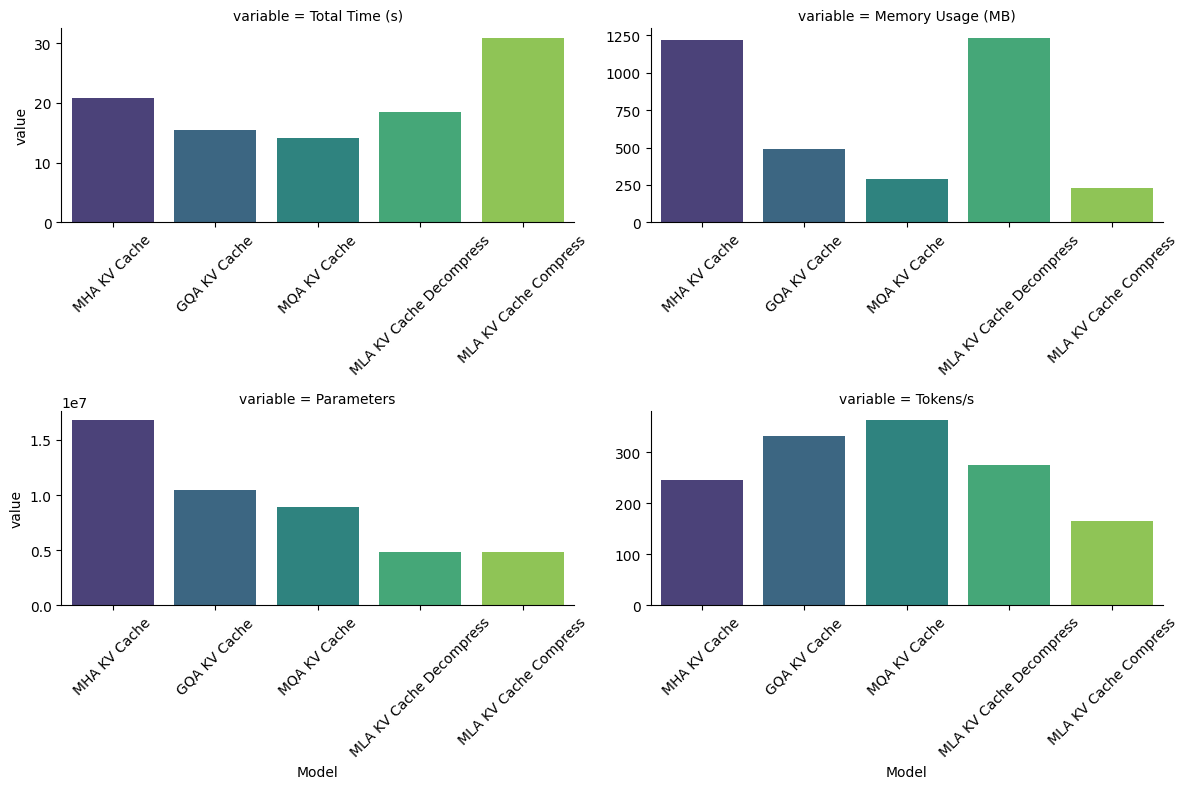

In [42]:
# Create a FacetGrid with 3 rows and 2 columns
fig = plt.figure(figsize=(12, 12))

# Define metrics to plot
metrics = [
    "Total Time (s)",
    "Memory Usage (MB)",
    "Parameters",
    "Tokens/s",
]

# Create facet grid for multiple plots
g = sns.FacetGrid(
    pd.melt(results_df, id_vars=["Model"], value_vars=metrics),
    col_wrap=2,
    height=4,
    aspect=1.5,
    row=None,
    col="variable",
    sharex=False,
    sharey=False,
)

# Plot bars for each metric
g.map_dataframe(
    sns.barplot,
    x="Model",
    y="value",
    hue="Model",
    palette="viridis",
)

# Rotate x-axis labels for better readability
for ax in g.axes:
    ax.tick_params(axis="x", rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## References
1. https://arxiv.org/pdf/1706.03762 Transformer
2. https://arxiv.org/pdf/2405.04434 MLA
3. https://arxiv.org/pdf/2305.13245v3 GQA